<a href="https://colab.research.google.com/github/gizemkaratas/Aygaz_YZ_Bootcamp_Projesi/blob/main/ecom_recommendation_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN Derin Öğrenme Modeli İle Beden ve Ürün Tavsiye Sistemi Oluşturma

**Proje Konusu ve Amacı** :Kullanıcı tarafından yüklenen fotoğrafın insan olup olmadığının tespitinden sonra beden ölçülerini tahminleyerek incelediği ürünler için beden tavsiyesinde bulunmak, vücut tipine uygun kıyafet önerilerinde bulunmak ve son aşama olarak beğendiği ya da tavsiye edilen kıyafetleri yüklediği fotoğrafa işlenmesini sağlamak amaçlanmıştır.
Bu şekilde müşteri memnuniyetini arttırmak, iade oranları düşürmek, müşterinin karar verme ve satın alma hızı arttırmak, yenilik içerdiği için dikkat çekecek bu da site ziyaretlerini ve dolayısıyla satışı arttırmak hedeflenmektedir.

**Proje Adımları:**

1. Yüklenen fotoğrafın insana ait olup olmadığının tespiti    
2. Yüklenen fotoğrafta işaretleme yöntemi ile beden ölçülerinin tahmin edilmesi
3. Yüklenen fotoğraf analiz edilerek vücut tipinin tahmin edilmesi
4. Tavsiye edilen ürünle yüklenen fotoğrafın birleştirilerek müşterinin ürünü direkt kendi üstünde görmesinin sağlanması.



##1- İlk Adım : CNN Modeli ile Kullanıcının Yüklediği Fotoğrafın Değerlendirilmesi


*   Birinci adım, fotoğrafın uygunluğunun tespiti: cifar100 veri seti kullanılmıştır, bu veri seti içerisinde 100 sınıf, 60 bin görüntü bulundurmaktadır.
*   Bu veri setini insan ve insan olmayan olarak iki ayrı sınıf olarak ayırarak modelin performansını, doğruluk oranı ve hızı arttırılmıştır.
*   Modelin performansı f1 score ve accuracy ile ölçüldükten sonra kullanıcının yüklediği resim için geri bildirimde bulunulmaktadır




**Gerekli Kütüphanelerin Yüklenmesi**




In [41]:
import numpy as np
from keras.datasets import cifar100
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from google.colab import files
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


**Veri Setinin Yüklenmesi**

In [42]:
(x_train, y_train), (x_val, y_val) = cifar100.load_data()

**Verileri Sınıflandırma**

In [43]:
# Değiştirilecek etiket numaraları
target_labels = [2, 11, 35, 41, 46, 98] #insana ait fotoğrafların label numaraları

# Etiketlerin değiştirilmesi:
y_train_binary = np.where(np.isin(y_train, target_labels), 1, 0)
y_val_binary = np.where(np.isin(y_val, target_labels), 1, 0)

**Veri Görselleştirme**

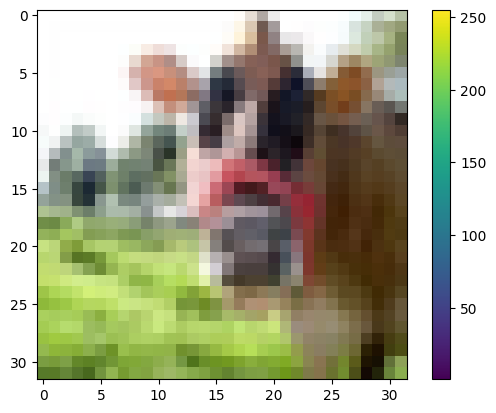

In [44]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

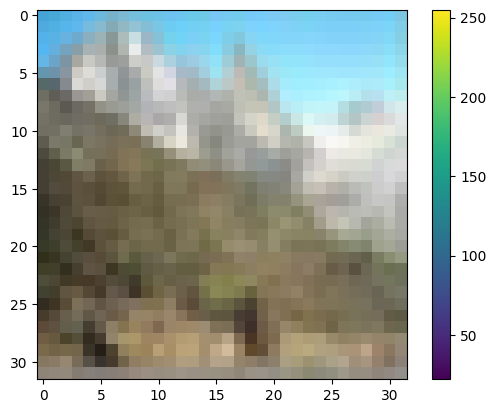

In [45]:
plt.figure()
plt.imshow(x_train[42])
plt.colorbar()
plt.grid(False)
plt.show()

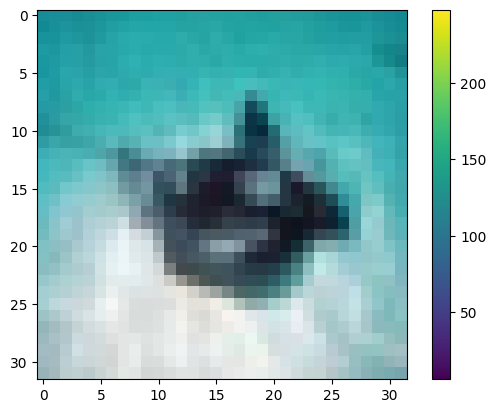

In [51]:
plt.figure()
plt.imshow(x_train[125])
plt.colorbar()
plt.grid(False)
plt.show()

**Verileri Normalize Edilmesi**



In [52]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0


**Veri Boyutu ve Sınıfı İnceleme**

In [53]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_val.shape)
print("y_test shape:", y_val.shape)
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Number of classes: 100


**CNN Modelinin Oluşturulması**

In [54]:
# Modeli tanımlayın:
model = Sequential()

#İlk Evrişim (Convolution) ve Normalizasyon (Batch Normalization) Katmanları:

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

#İkinci Evrişim ve Normalizasyon Katmanları:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

#Üçüncü Evrişim ve Normalizasyon Katmanları:
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((1, 1)))  # Changed pooling size to (1, 1)
model.add(Dropout(0.25))

#Düzleştirme (Flatten) ve Tam Bağlantılı (Fully Connected) Katmanlar:

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

**Modelin Derlenmesi**

In [55]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

**Modelin Performansını Arttırma**

In [56]:
# Early stopping ve learning rate reduction callback'leri eklenmesi:


early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)

# Görüntü veri artırımı (image data augmentation) işlemi:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


**Modelin Eğitilmesi**

In [57]:
history = model.fit(datagen.flow(x_train, y_train_binary, batch_size=64),
                    epochs=25,
                    validation_data=(x_val, y_val_binary),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/25
782/782 [==============================] - 239s 302ms/step - loss: 0.2136 - accuracy: 0.9351 - val_loss: 0.2449 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 2/25
782/782 [==============================] - 242s 309ms/step - loss: 0.1811 - accuracy: 0.9429 - val_loss: 0.1812 - val_accuracy: 0.9438 - lr: 0.0010
Epoch 3/25
782/782 [==============================] - 230s 293ms/step - loss: 0.1666 - accuracy: 0.9462 - val_loss: 0.1486 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 4/25
782/782 [==============================] - 230s 294ms/step - loss: 0.1534 - accuracy: 0.9518 - val_loss: 0.1508 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 5/25
782/782 [==============================] - 233s 298ms/step - loss: 0.1464 - accuracy: 0.9536 - val_loss: 0.1835 - val_accuracy: 0.9458 - lr: 0.0010
Epoch 6/25
782/782 [==============================] - 242s 309ms/step - loss: 0.1352 - accuracy: 0.9566 - val_loss: 0.1330 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 7/25
782/782 [==========================

In [58]:
# prompt: yukarıdaki modeli kaydedilmesi

model.save('my_model.h5')


In [59]:
# prompt: kaydettiğim modeli yüklenmesi

from keras.models import load_model

# Modeli yükle
model = load_model('my_model.h5')


**Veri Görselleştirme**

1/1 [==============================] - 0s 24ms/step


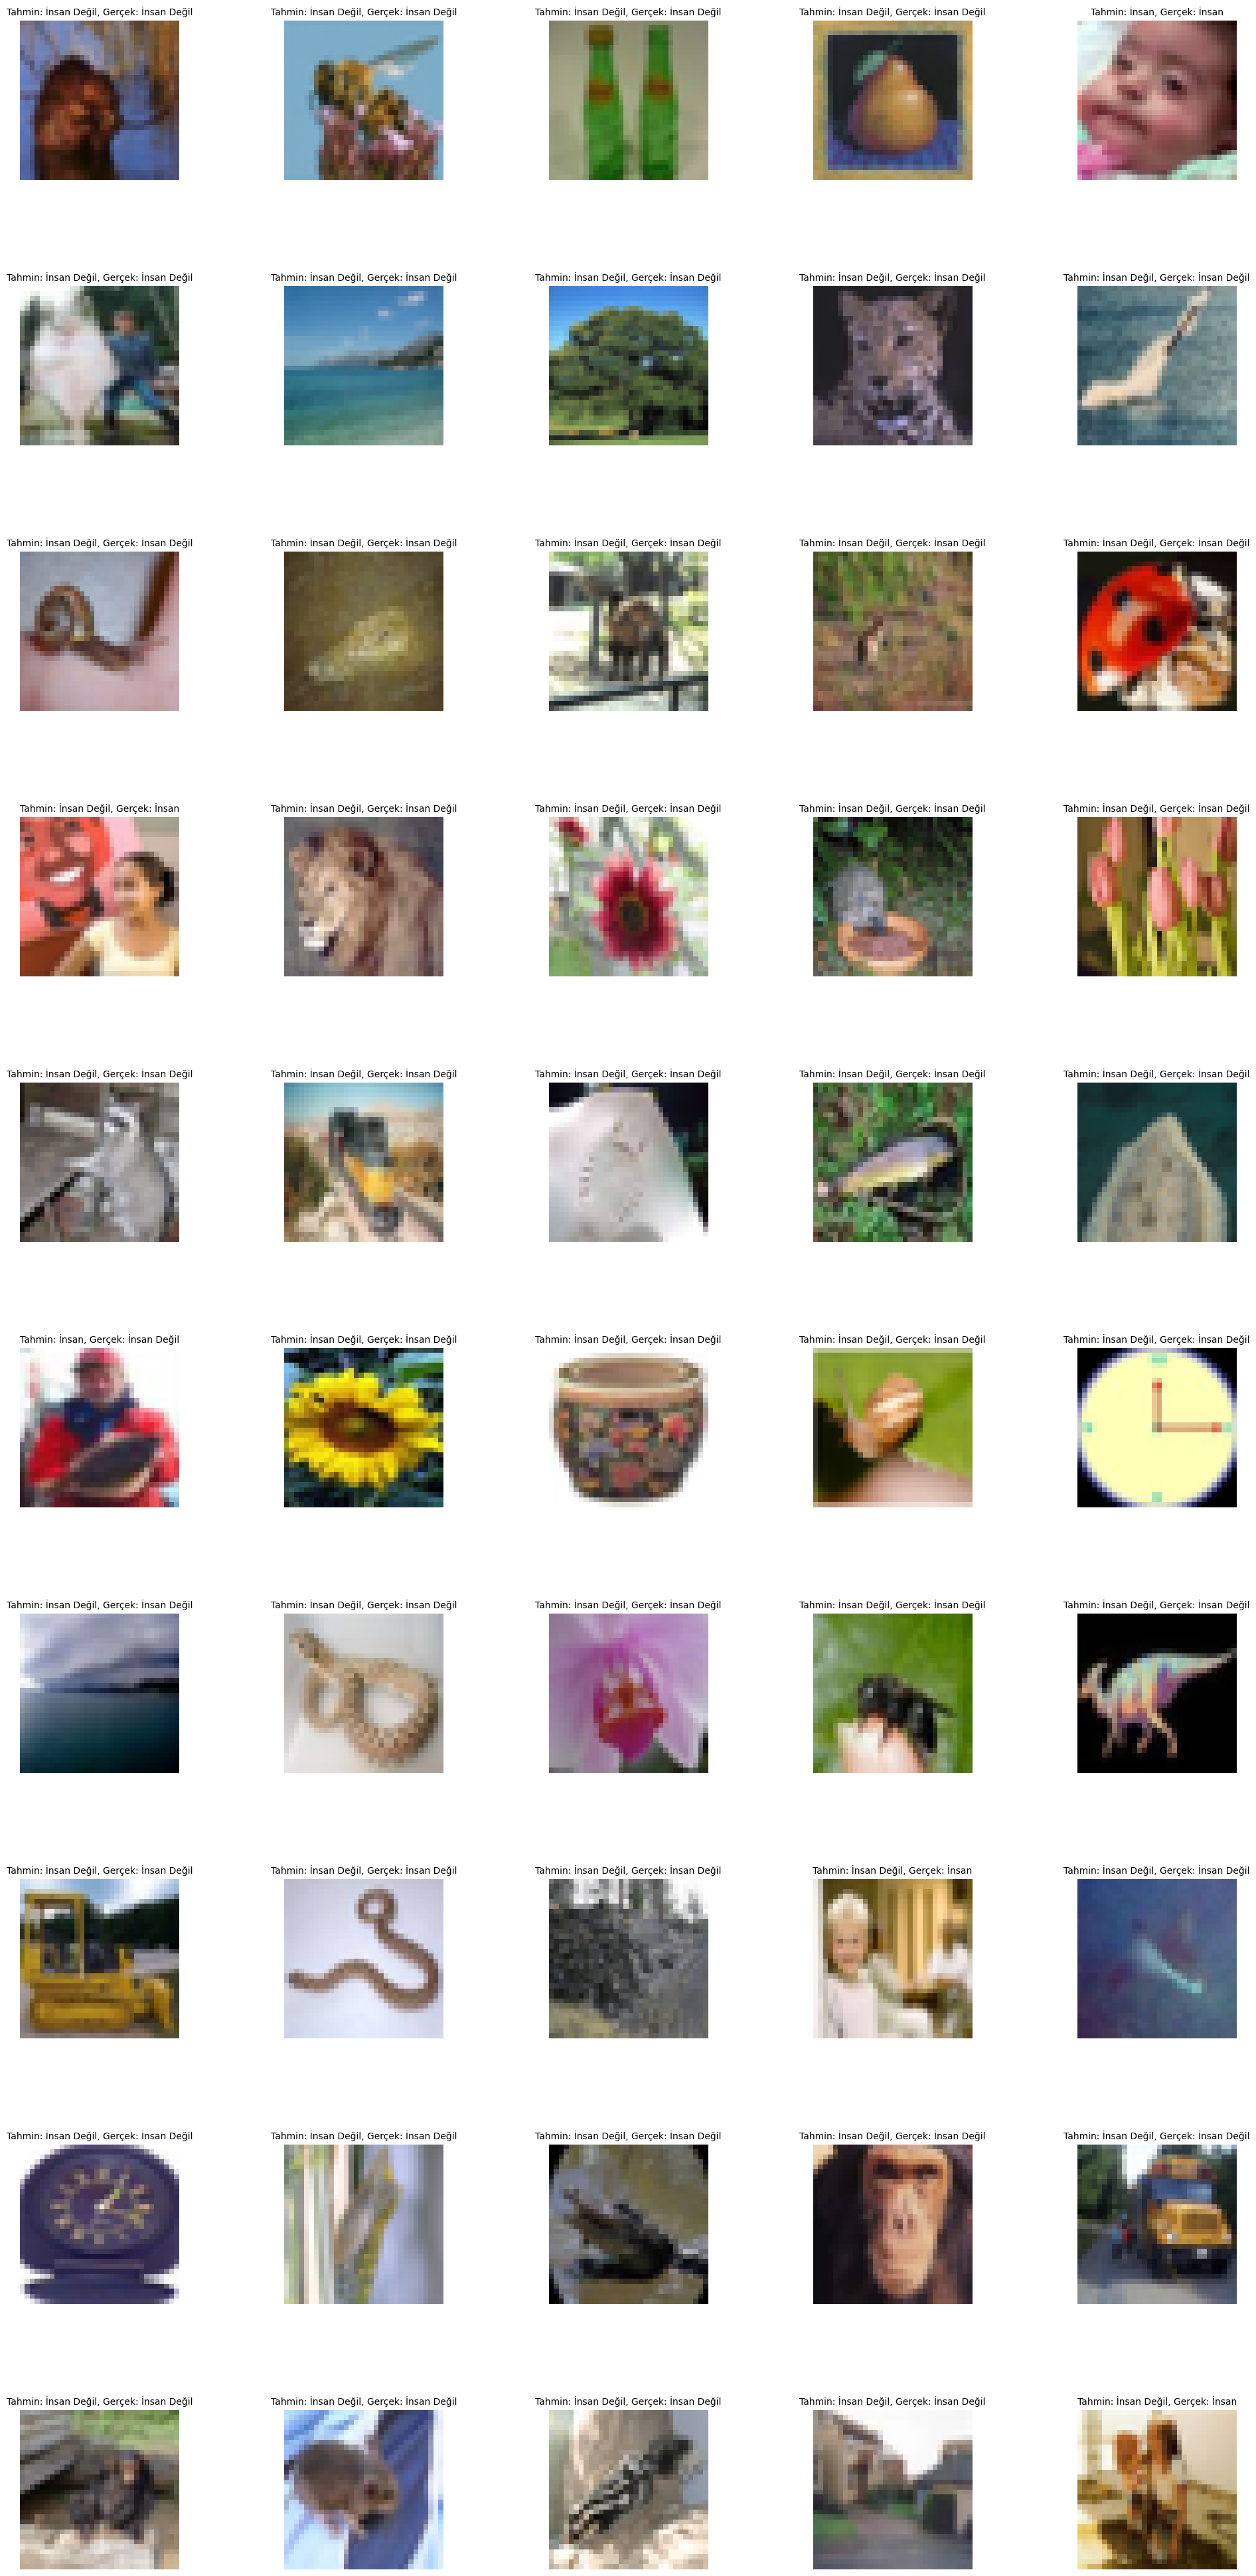

In [60]:
# Verinin 50 ile 100 arasını tahmin edip görselleştirilmesi:
fig, axs = plt.subplots(10, 5, figsize=(20, 40))
fig.subplots_adjust(hspace=0.6, wspace=0.6)

# 50'den 100'e kadar olan indeksler arasında döngü yapın ve 'axs'ye erişim için indeksi ayarlanması:
for i in range(50, 100):
    x = x_val[i]
    y = y_val_binary[i]

    # Resmi, bir batch boyutu içerecek şekilde yeniden şekillendirilmesi:
    image_batch = x.reshape(1, 32, 32, 3)
    prediction = model.predict(image_batch)[0]

    # axs için doğru indeksi elde etmek amacıyla 'i' den 50 çıkarılması:
    ax = axs[(i - 50) // 5, (i - 50) % 5]
    ax.imshow(x)
    ax.set_title(f'Tahmin: {"İnsan" if prediction >= 0.5 else "İnsan Değil"}, Gerçek: {"İnsan" if y == 1 else "İnsan Değil"}', fontsize=10)  # Yazı boyutunu ayarladık
    ax.axis('off')

plt.tight_layout(pad=5.0, h_pad=10.0, w_pad=10.0)
plt.show()

**Veri Görselleştirme**

1/1 [==============================] - 0s 23ms/step


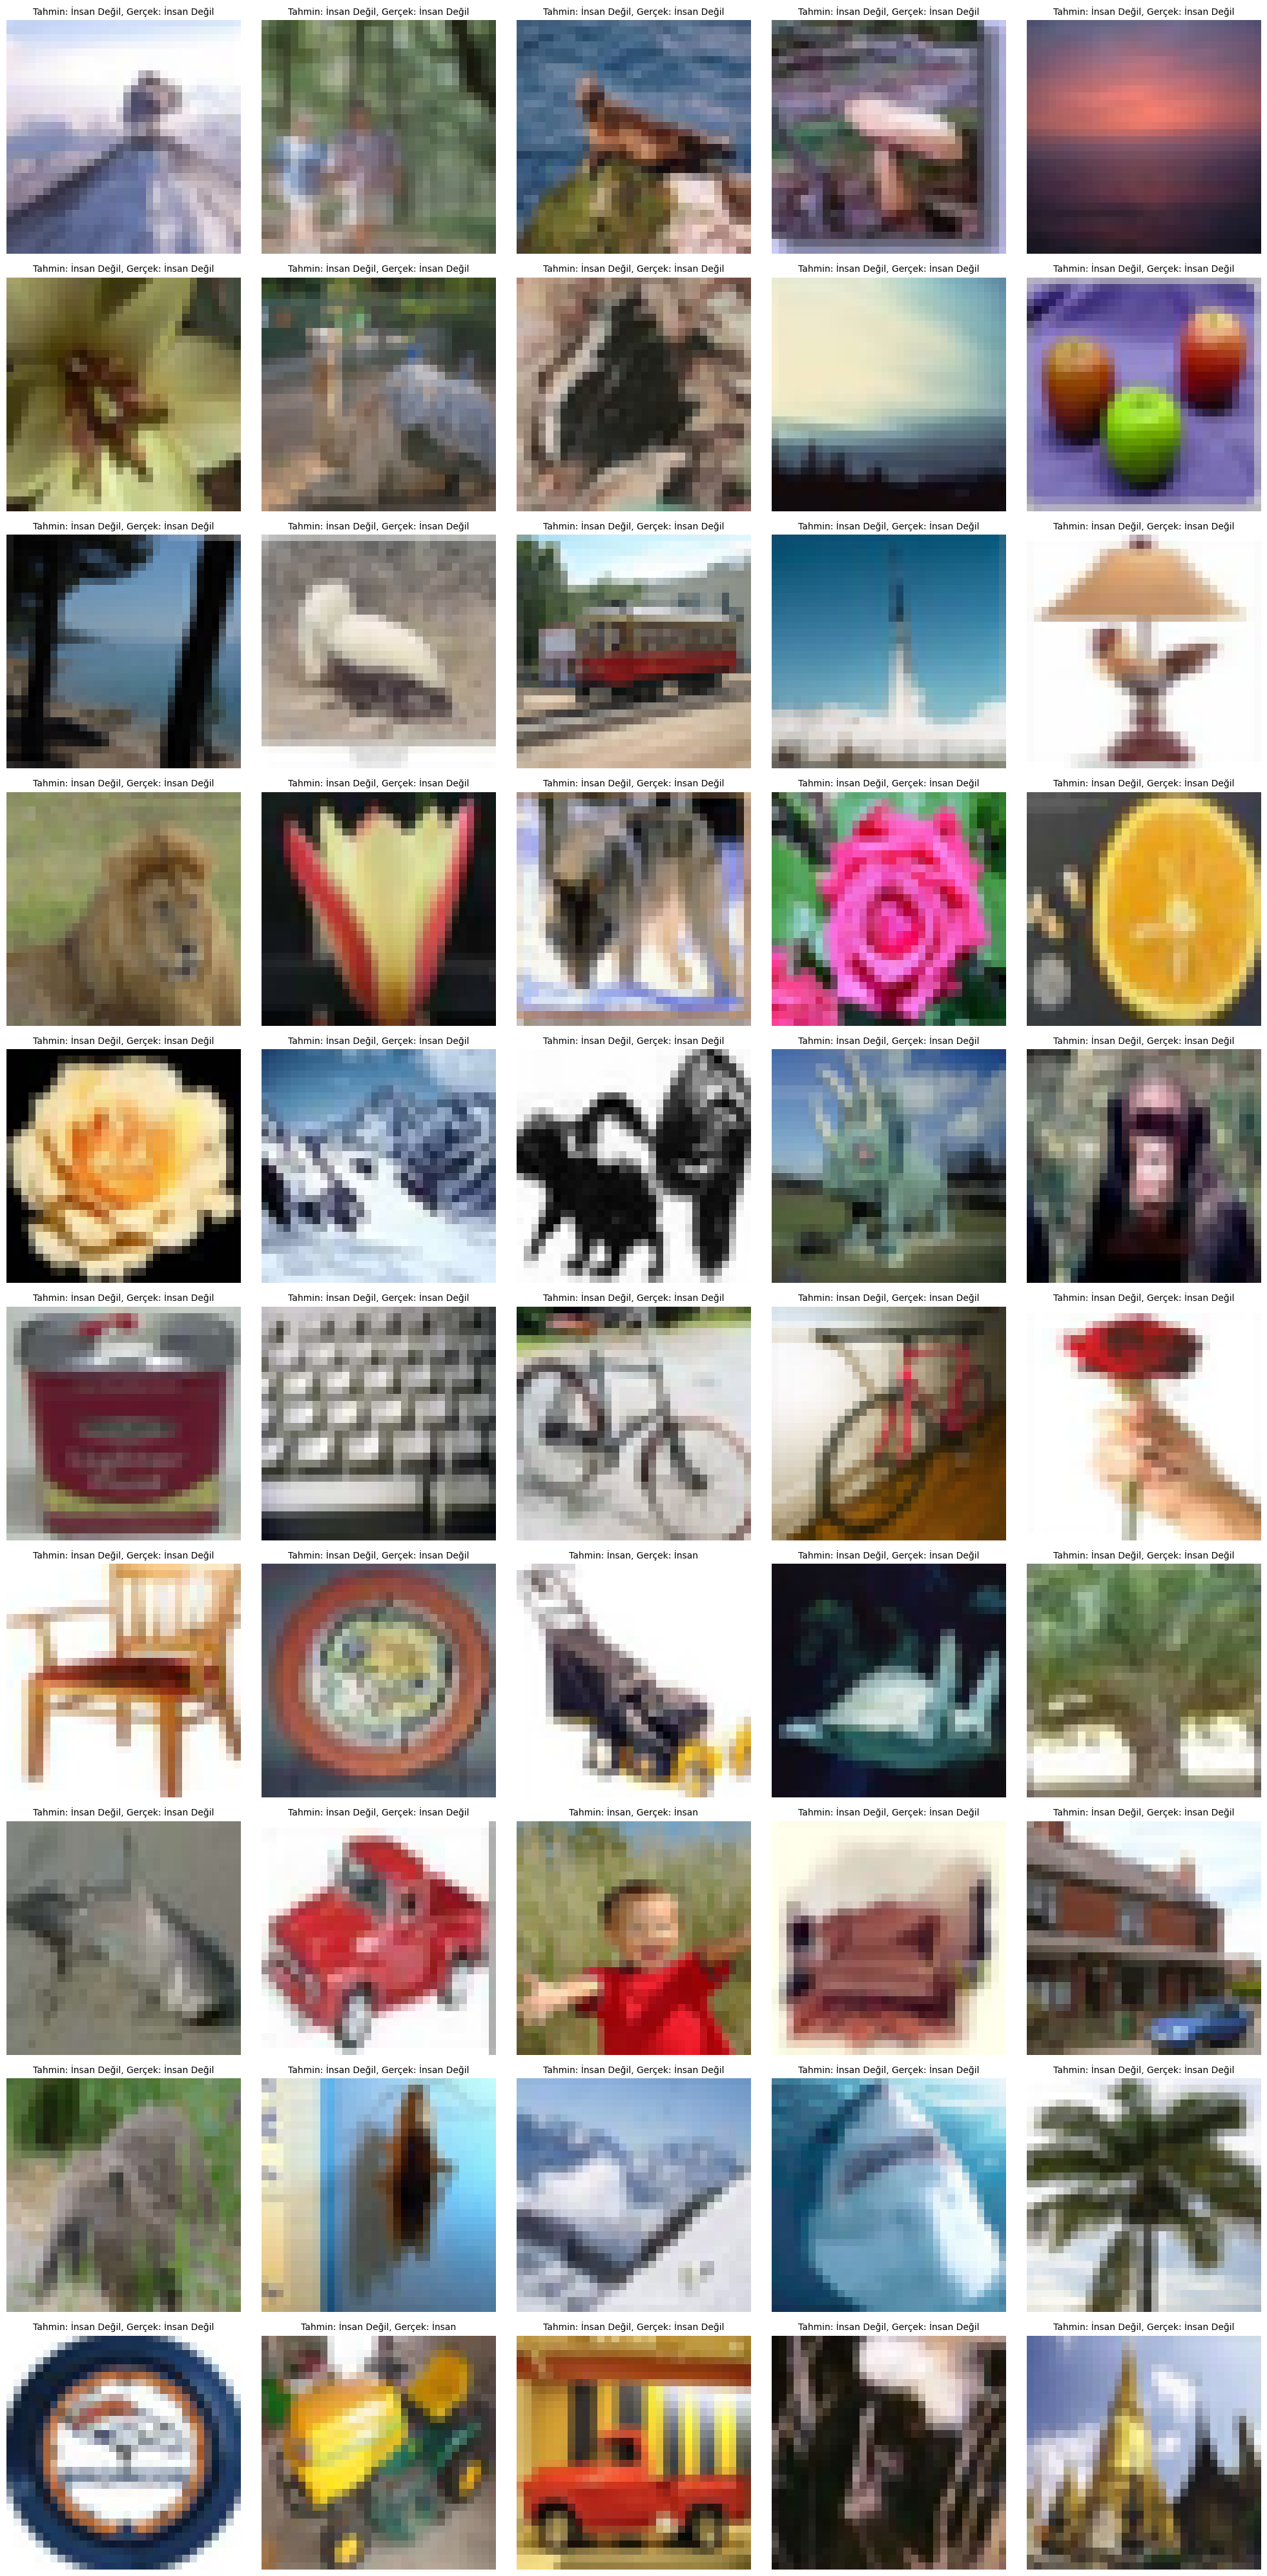

In [61]:
# Verinin ilk 50 tanesini tahmin edip görselleştirin
fig, axs = plt.subplots(10, 5, figsize=(20, 40))
fig.subplots_adjust(hspace=0.6, wspace=0.6)

for i in range(50):
    x = x_val[i]
    y = y_val_binary[i]

    # Görüntüyü bir batch boyutu eklemek için yeniden şekillendirilmesi:
    image_batch = x.reshape(1, 32, 32, 3)
    prediction = model.predict(image_batch)[0]

    ax = axs[i // 5, i % 5]
    ax.imshow(x)
    ax.set_title(f'Tahmin: {"İnsan" if prediction >= 0.5 else "İnsan Değil"}, Gerçek: {"İnsan" if y == 1 else "İnsan Değil"}', fontsize=10)  # Yazı boyutunu ayarladık
    ax.axis('off')

plt.tight_layout()
plt.show()


**Modelin Performansını Değerlendirme**

**Sonucun Grafikleştirilmesi**

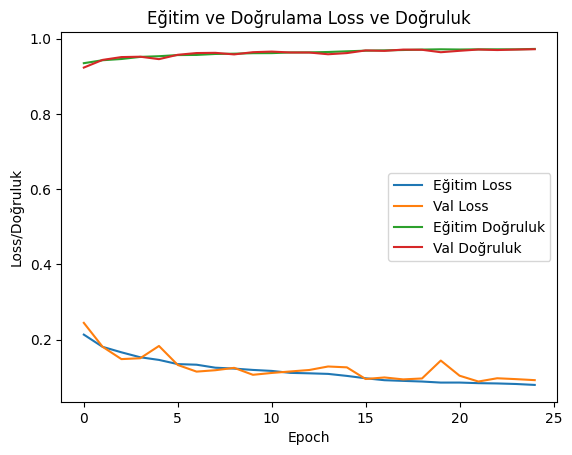

In [83]:
# Eğitim ve doğrulama kayıplarını çizin
plt.plot(history.history["loss"], label="Eğitim Loss")
plt.plot(history.history["val_loss"], label="Val Loss")

# Eğitim ve doğrulama doğruluklarını çizin
plt.plot(history.history["accuracy"], label="Eğitim Doğruluk")
plt.plot(history.history["val_accuracy"], label="Val Doğruluk")

# Grafik başlığı ve eksen etiketleri ekleyin
plt.title("Eğitim ve Doğrulama Loss ve Doğruluk")
plt.xlabel("Epoch")
plt.ylabel("Loss/Doğruluk")
plt.legend()

# Grafikleri gösterin
plt.show()

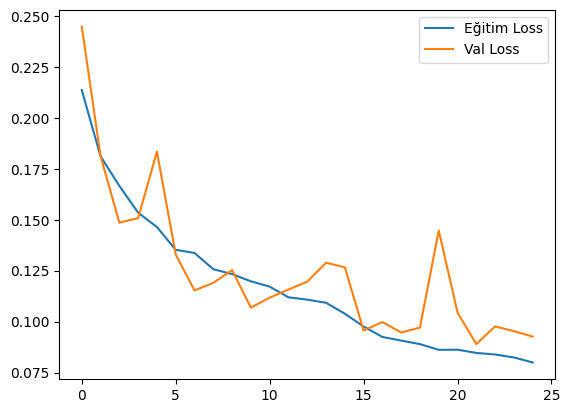

In [85]:
plt.figure()
plt.plot(history.history["loss"], label="Eğitim Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

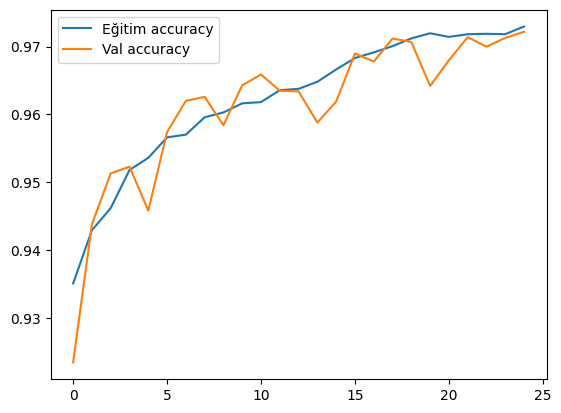

In [87]:
plt.figure()
plt.plot(history.history["accuracy"], label="Eğitim accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.legend()
plt.show()

**Kullanıcı Fotoğraf Yükleme Butonu**

In [1]:
img= files.upload()

NameError: name 'files' is not defined

**Fotoğrafın Değerlendirilmesi**

In [97]:
def predict_image(model, img_path):

    #Resmin Yüklenmesi:
    img = Image.open(img_path)
    # Resmin yeniden boyutlandırılması:
    resized_img = img.resize((32, 32))
    # Yeniden boyutlandırılmış resmi kaydedilmesi:
    resized_img.save('./photo.jpeg')
    img_path = './photo.jpeg'

    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array / 255.0)

    prediction = model.predict(img_array)
    print(prediction)
    if prediction >= 0.5:
        print("Bu bir insan.")
    else:
        print("Uygun değil, başka bir görselle deneyiniz.")
predict_image(model,"WhatsApp Image 2024-05-02 at 11.45.38.jpeg")

1/1 [==============================] - 0s 22ms/step
[[0.]]
Uygun değil, tekrar deneyiniz.
